<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/logique_floue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logique floue avec skfuzzy

L'obejctif est de pouvoir représenter des règles de type :
- Si quelqu'un est trop près du bord de route, alors freiner fortement
- Si un enfant se trouve au centre du trottoir, alors freiner fortement
- Si une personne grande se trouve au centre du trottoir, alors freiner moyennement
- Si une personne est loin du bord de route, alors freiner légèrement..

On utilise pour cela la librairie python skfuzzy
*(si elle n'est pas présente, installez là avec cette ligne : !pip install -U scikit-fuzzy)*

In [2]:
!pip install -U scikit-fuzzy

    100% |████████████████████████████████| 1.0MB 20.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/9d/f9/0e/a8de3e98e64bbf828f5e762936ff5a40e72331dbe663470711
Successfully built scikit-fuzzy


In [1]:
#les imports
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## les antécédents et les conséquents
- Les antécédents sont les variables utilisées pour prendre les décisions (ici taille de la personne et proximité au bord de route)
- les conséquents sont les déductions (ici le freinage)

In [2]:
#### Antecedent et Consequent
# la taille est située dans un intervale de 0 à 200 coupé par pas de 5 
taille = ctrl.Antecedent(np.arange(0,200,5), 'taille')
# la proximitée du bord est située dans un intervale de 0 à 200 coupé par pas de 5 
proximite_bord = ctrl.Antecedent(np.arange(0,200,5), 'proximite_bord')
# le freinage est situé dans un intervale de 0 à 100 coupé par pas de 2 
frein = ctrl.Consequent(np.arange(0,100,2), 'frein')

### intervales
on définit ensuite les intervales utilisés dans les antécédents et les conséquents.
Par exemple, 
- taille sera découpée en 'pre-ado' et 'post-ado'
- bord sera découpé en 'trop-pres', 'central', 'loin'
- frein sera découpé en 'fort', 'moyen', 'léger'

Il faut donner les courbes d'appartenances à ces intervales : 

In [3]:
#une courbe trapezoïdale, petit=1 jusque 120cm, petit=0 à partir de 160cm
taille_petit = fuzz.trapmf(taille.universe, [0, 0, 120,160])
#une courbe trapezoïdale, grand=0 jusque 130cm, grand=1 à partir de 170cm
taille_grand = fuzz.trapmf(taille.universe, [130, 170, 200,200])
taille['pre'] = taille_petit
taille['post'] = taille_grand


On peut vérifier les courbes d'appartenance : 

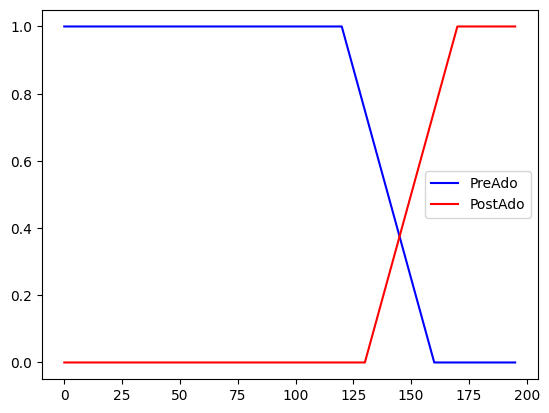

In [4]:
plt.plot(taille.universe, taille_petit, 'b',  label='PreAdo')
plt.plot(taille.universe, taille_grand, 'r',  label='PostAdo')
plt.legend()
plt.show()



 On *joue* un peu avec les types de courbes : 



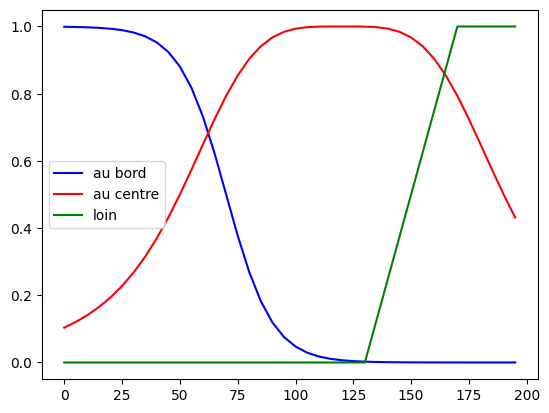

In [5]:
#une sigmoide qui descend afin que s(70) = 0.5
bord_proche = fuzz.sigmf(proximite_bord.universe, 70,-0.1)
#une courbe en cloche qui donne une bonne valeur à 70, une valeur de 1 à 120 et descend ensuite de façon symétrique
bord_central = fuzz.gbellmf(proximite_bord.universe, 70, 2, 120)
#un trapèze tronqué qui grimpe à partir de 130 juque 170
bord_loin = fuzz.trapmf(proximite_bord.universe, [130, 170, 200,200])
proximite_bord['troppres'] = bord_proche
proximite_bord['centre'] = bord_central
proximite_bord['loin'] = bord_loin
#juste pour voir les courbes
plt.plot(proximite_bord.universe, bord_proche, 'b',  label='au bord')
plt.plot(proximite_bord.universe, bord_central, 'r',  label='au centre')
plt.plot(proximite_bord.universe, bord_loin, 'g',  label='loin')
plt.legend()
plt.show()

Il reste à définir les intervales pour le freinage : 

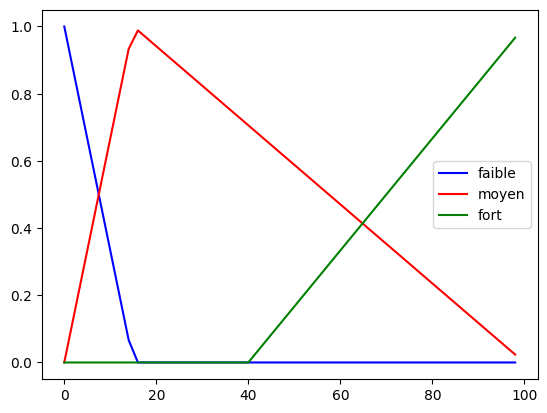

In [6]:
#triangle légèrement tronqué 0 en 0, 1 en 0, et 0 en 15
frein_faible = fuzz.trimf(frein.universe, [0, 0, 15])
#triangle légèrement tronqué 0 en 0, 1 en 15, et 0 en 100
frein_moyen = fuzz.trimf(frein.universe, [0, 15, 100])
#triangle légèrement tronqué 0 en 40, 1 en 100, et 0 en 100 (non pris en compte)
frein_fort = fuzz.trimf(frein.universe, [40, 100, 100])
frein['faible'] = frein_faible
frein['normal'] = frein_moyen
frein['fort'] = frein_fort

#toujours juste pour voir...
plt.plot(frein.universe, frein_faible, 'b',  label='faible')
plt.plot(frein.universe, frein_moyen, 'r',  label='moyen')
plt.plot(frein.universe, frein_fort, 'g',  label='fort')
plt.legend()
plt.show()


##Définition des règles floues
Rappel, on souhaite définir : 
- Si quelqu'un est trop près du bord de route, alors freiner fortement
- Si la personne petite ET qu'elle se trouve au centre du trottoir, alors freiner fortement
- Si  la personne grande ET qu'elle se trouve au centre du trottoir, alors freiner moyennement
- Si une personne est loin du bord de route, alors freiner légèrement..


In [7]:
#on écrit
rule1 = ctrl.Rule( proximite_bord['troppres'], frein['fort'])
rule2 = ctrl.Rule(taille['pre'] & proximite_bord['centre'], frein['fort'])
rule3 = ctrl.Rule(taille['post'] & proximite_bord['centre'], frein['normal'])
rule4 = ctrl.Rule(proximite_bord['loin'], frein['faible'])

#on compile les règles
frein_regles = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
freinage = ctrl.ControlSystemSimulation(frein_regles)

##Observations
Testons le système : 
- une personne de 180cm a été captée à 80cm du bord de la route, quelle est la décision à prendre ?

In [33]:
freinage.input['taille'] = 180
freinage.input['proximite_bord'] = 80

freinage.compute()

print(f"le freinage doit donc être de l'ordre de {freinage.output['frein']: .2f}%")

le freinage doit donc être de l'ordre de  41.09%


Vérifions en image

/Users/emmanueladam/Library/Python/3.9/lib/python/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


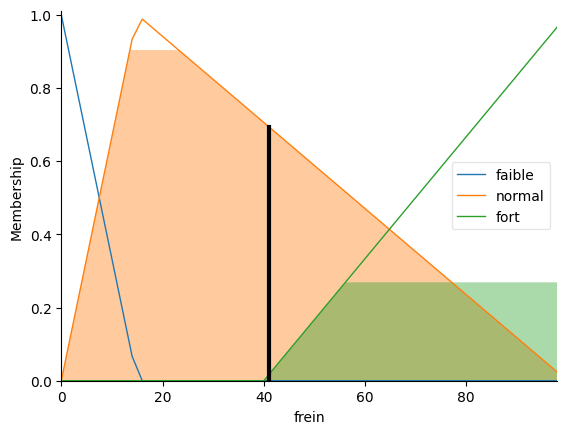

In [9]:
frein.view(sim=freinage)

Que se passe-t-il lorsque la personne perçue mesure 1m et qu'elle se trouve à 40 cm du bord ?


In [29]:
freinage.input['taille'] = 100
freinage.input['proximite_bord'] = 160

freinage.compute()

print(f"le freinage doit être de l'ordre de {freinage.output['frein']: .1f}%")

le freinage doit être de l'ordre de  63.8%


un freinage à 80% est recommandé

/Users/emmanueladam/Library/Python/3.9/lib/python/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


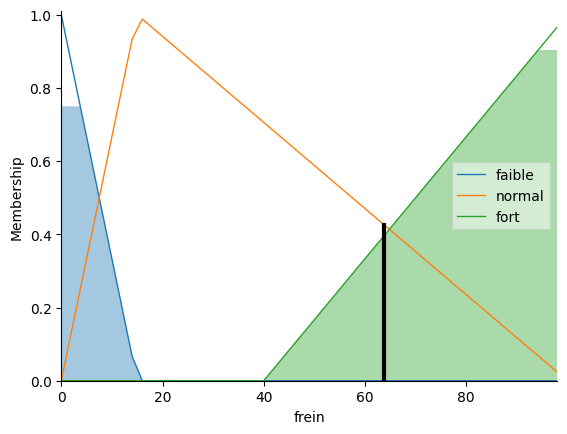

In [30]:
frein.view(sim=freinage)

**On remarque un problème !** les conclusions freinage fort et faible s'activent mais pas le freinage normal !
- expliquez cela
- proposer une amélioration